In [69]:
# only used for the Jupyter Notebook version:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from geopy.distance import distance

## This function is only needed in Jupyter Notebooks. In the actual code, this will be handled by load_datasets() instead

In [70]:
def concat_datasets(files):
    
    dslist = []
    for fname in files:
        ds = xr.open_dataset(fname)
        dslist.append(ds)
    
    ds = xr.concat(
        dslist,
        pd.Index([ds.obs_buoyid for ds in dslist],
                 name='buoyid')
    )
    
    return ds

## These two functions come directly from the drift-tool code. Instead of including them in the new code, I'll just refer to the existing versions when the code moves to the GPSC (ie: map_functions.plot_land_mask() and map_functions.calculate_hexbin_size())

In [81]:
from collections import namedtuple
LatLonBoundingBox = namedtuple('LatLonBoundingBox',
                               ('lat_min', 'lat_max', 'lon_min', 'lon_max'))

def plot_gshhs_landmask(bbox, ax):

    # if the bbox has been passed in as a list, adjust it.
    if isinstance(bbox, list):
        bbox = LatLonBoundingBox(lon_min=bbox[0], lat_min=bbox[2],
                                 lon_max=bbox[1], lat_max=bbox[3])

    # Decide how high a resolution to use based on the size of the
    # geographical area. Calculate the distance along a diagonal, then
    # select the resolution based on that value. The resolution levels
    # were arbitrarily chosen based on a plot of CIOPS-W data and may
    # still need to be tweaked to get the nicest plots possible.
    lr = (bbox.lat_min, bbox.lon_max)
    ul = (bbox.lat_max, bbox.lon_min)
    dist_calc = distance(ul, lr).m
    if dist_calc < 1000000:
        res = 'full'
    elif dist_calc < 3000000:
        res = 'high'
    else:
        res = 'intermediate'

    # Actually add the land. The scale represents the dataset scale
    # (either ‘auto’, ‘coarse’, ‘low’, ‘intermediate’, ‘high, or
    # ‘full’ with a default of ‘auto’). levels is a list of integers
    # from 1-4 corresponding to the desired GSHHS feature levels to
    # draw (default is [1] which corresponds to coastlines only).
    ax.add_feature(
        cfeature.GSHHSFeature(
            scale=res,
            levels=[1],
            edgecolor='black',
            facecolor='lightgray',
            linewidth=0.1,
            alpha=1.0,
            zorder=1
            )
        )


def calculate_hexbin_size(fig, ax, map_extremes):
    """ helper function used to determine a visually pleasing hexbin size
    based on the data provided and the size of the figure. In the past,
    this was handled by matplotlib.pyplot.hexbin() directly when a user
    provided a single int for grid_spacing. When plotting with Cartopy,
    this no longer seems to work as it did previously. Providing a tuple
    value tailored to the plot for grid_spacing gives a more consistent
    result. Currently, this has only been tested using the PlateCaree()
    projection, but will potentially work for other projections as well.

    Parameters
    ---------
    fig : figure
        current matplotlib figure
    ax : Axes
        current axis for the plot
    map_extremes : list
        list of the bounding box values of the plot in the form
        [minlon, maxlon, minlat, maxlat]

    Returns
    -------
    hexbin_size : tuple
        tuple with gridsize information to be used when plotting the hexbins
    """

    # The hexbin size needs to be based both on the size of the figure
    # window and also on the extent of the data. This helps avoid hexbins
    # that are too small / too large or oddly stretched.

    # calculate the distance across the center of the plot
    minlon, maxlon, minlat, maxlat = map_extremes
    midlat = (maxlat - minlat)
    midlon = (maxlon - minlon)
    horzdist = distance((midlat, minlon), (midlat, maxlon)).m
    vertdist = distance((minlat, midlon), (maxlat, midlon)).m

    # data aspect ratio
    aspratio = vertdist / horzdist

    # get the figure aspect ratio
    ax_pos = ax.get_position()
    fig_aspect = ax_pos.height / ax_pos.width

    # get the figure dimensions in pixels
    fig_width, fig_height = fig.get_size_inches() * fig.dpi

    # set a default horizontal hexsize (we use 9 by default)
    hex_size_px = 7
    
    # choose how much to adjust the height of the hexbin
    # (a value less than one makes a taller hexbin)
    hex_ratio_adjustment = 0.6
    
    if fig_aspect > 1:
        # tall figure
        vsize = fig_height / hex_size_px
        startsize = int(round(vsize / fig_aspect))
    else:
        # wide (or square) figure
        startsize = int(round(fig_width / hex_size_px))

    adjsize = int(round(startsize * aspratio, 0))

    # define the gridsize tuple to be passed to ax.hexbin()
    hexsize = (startsize, int(adjsize * hex_ratio_adjustment))
    
    return hexsize

## This code is also already in the drift-tool, but I've modified it here so that it no longer produces a warning when the lon value is NaN. Is there another way around this warning though? Or is there a way to avoid the warning while not looping though individual lons like what's done in the original version of wrap_to_180?

In [82]:
def wrap_to_180(x):
    """Wrap values in degrees into the interval [-180, 180]."""
    xwrap = []
    for num in x:
        if np.isnan(num):
            xwrap.append(num)
        else:
            xnew = np.remainder(num, 360)
            if xnew > 180: 
                xnew -= 360
            xwrap.append(xnew)        

    return xwrap

## This function just adds some extras to the plots (like landmask, aspect ratio and gridlines). I'm calling it in a separate function because it's used in all 4 plots. I'll probably just call the individual functions directly from the main plotting function instead when it comes time to do the actual drift-tool version.

In [133]:
def refine_map(ax, bbox):

    def show_missing_islands(ax):
        """ alternate method of drawing the land """
        # set the facecolor of the plot to the same color as the land,
        # then add a white ocean over the top. This is a work around
        # to handle the fact that some islands are missing from the
        # coastline data.
        ax.set_facecolor('lightgray')

        # add the land, even though it's missing some islands
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        # set the ocean color and add an edge color so that the 
        # islands will be outlined.
        ax.add_feature(cfeature.OCEAN, 
                       facecolor='white', 
                       edgecolor='black', 
                       linewidth=0.5)
    
    # add the land in the same way as the drift-tool
    plot_gshhs_landmask(bbox, ax)
       
    # set the aspect ratio to produce a square map
    ax.set_aspect('equal', adjustable='datalim', anchor='C')
    plt.draw()

    # draw parallels and meridians
    ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=['bottom', 'left'],
        xformatter=LongitudeFormatter(),
        xlabel_style={'rotation': 45, 'ha': 'center'},
        yformatter=LatitudeFormatter(),
        ylabel_style={'rotation': 45, 'ha': 'center'},
        linestyle=(0, (5, 5)),
        color='darkgray',
        linewidth=0.5
    )

## This function isn't sitting well with me. It's used to calculate the color / size values for the bubble plots and to calculate the min/max values of the bins to set the color bar symmetric around zero, but I feel like there must be a better way to do this? I find it odd that there doesn't seem to be a built in method to calculate the same stats as plt.hexbin() without actually generating the plot first. Maybe I can use np.histogram2d() to get the color and size values instead of trying to replicate the values from the hexbin plot? 

In [134]:
def get_stats_info(lats, lons, speed_ocean_error, hexsize):
    """ I'm concerned about this function. I'm not sure that 
    this is the best way to calculate the values used in the
    bubble plot? """
    
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
     
    # set up a dictionary for the output
    stats = {}
    
    ######################################
    # get the number of points per bin:
    ######################################
    mesh = ax.hexbin(
        lons, lats,  
        transform=ccrs.PlateCarree(),
        gridsize=hexsize,
        mincnt=1,
    )  
    bin_xy = mesh.get_offsets()
    stats['bin_counts'] = mesh.get_array()  
    stats['lons_counts'], stats['lats_counts'] = zip(*bin_xy)
    ax.clear()
    
    ######################################
    # get the number value of each hexbin:
    ######################################
    mesh_vals = ax.hexbin(
        lons, lats,
        C=speed_ocean_error,
        transform=ccrs.PlateCarree(),
        gridsize=hexsize,
    )
    bin_xy_vals = mesh_vals.get_offsets()
    stats['bin_vals'] = mesh_vals.get_array()  
    stats['lons_vals'], stats['lats_vals'] = zip(*bin_xy_vals)
    ax.clear()
    
    plt.close()
    
    return stats


def find_extremes_centered_on_zero(data):
    """ helper function used to define the colorbar min/max """
    minval = np.nanmin(data)
    maxval = np.nanmax(data)
    extreme = (np.nanmax([abs(minval), abs(maxval)]))
    extremes = (-1 * extreme, extreme)
    return extremes

## Point at the data and create a concatonated dataset (these steps won't be necessary on the GPSC)

In [135]:
datadir = "C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_velocity_error_plots/sample_input_files/"
plotdir = "C:/Users/HoldenJe/Drift/projects/DriftCorrectionFactor/DCF_velocity_error_plots/output_plots/"

files = glob.glob(os.path.join(datadir, '*.nc'))
files.sort()

ds = concat_datasets(files)

## Make the error hexes plot

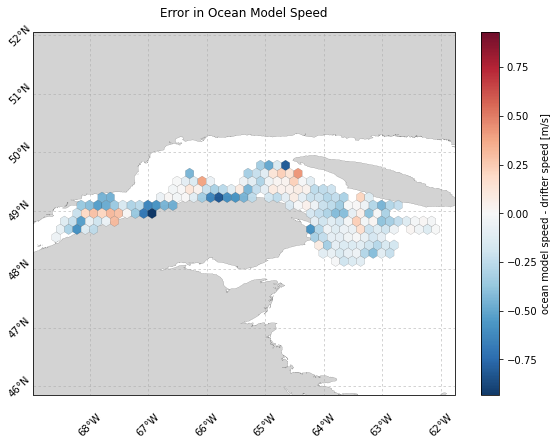

In [143]:
def plot_error_hexes(ds):
    
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    
    # define the variables for convenience
    lons = wrap_to_180(np.concatenate(ds.lon.values))
    lats = np.concatenate(ds.lat.values)
    speed_ocean_error = np.concatenate(ds.speed_ocean_error.values)
    map_extremes = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
    
    # calculate the hexbin size, bin values and number of counts per bin
    hexsize = calculate_hexbin_size(fig, ax, map_extremes)
    stats = get_stats_info(lats, lons, speed_ocean_error, hexsize)
    vextremes = find_extremes_centered_on_zero(stats['bin_vals'])

    mesh = ax.hexbin(
        lons, lats, 
        C=speed_ocean_error, 
        vmin=vextremes[0],
        vmax=vextremes[1],
        cmap='RdBu_r',
        transform=ccrs.PlateCarree(),
        gridsize=hexsize,
        edgecolor='black',
        linewidth=0.1,
        mincnt=1,
        zorder=100,
        alpha=0.95
    )

    bin_xy = mesh.get_offsets()
    bin_counts = mesh.get_array()
    arr = mesh.get_array()
       
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label('ocean model speed - drifter speed [m/s]')    
    
    # add coastlines, land, gridlines, etc
    refine_map(ax, map_extremes)
    ax.set_title('Error in Ocean Model Speed')

    # Tidy up the plot then save it.
    fig.tight_layout()
    fig.savefig(
        os.path.join(plotdir, ('error_in_ocean_model_speed.png')),
        bbox_inches='tight',
        dpi=300
    )
    plt.show()
    plt.close()
    
plot_error_hexes(ds)

## Make the counts plot

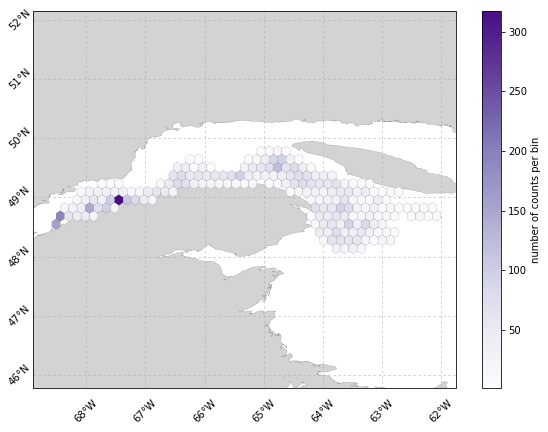

In [137]:
def plot_counts(ds):
    
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
          
    
    # define the variables for convenience
    lons = wrap_to_180(np.concatenate(ds.lon.values))
    lats = np.concatenate(ds.lat.values)
    speed_ocean_error = np.concatenate(ds.speed_ocean_error.values)
    map_extremes = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
    
    # calculate the hexbin size, bin values and number of counts per bin
    hexsize = calculate_hexbin_size(fig, ax, map_extremes)
    stats = get_stats_info(lats, lons, speed_ocean_error, hexsize)
       
    countplt = ax.hexbin(
        stats['lons_counts'], stats['lats_counts'], 
        C=stats['bin_counts'],
        transform=ccrs.PlateCarree(),
        gridsize=hexsize,
        cmap='Purples',
        edgecolor='black',
        linewidth=0.1,
        zorder=100,
        alpha=0.95
    )
    
    cbar = plt.colorbar(countplt, ax=ax)
    cbar.set_label('number of counts per bin')  

    # add coastlines, land, gridlines, etc
    refine_map(ax, map_extremes)

    # Tidy up the plot then save it.
    fig.tight_layout()
    fig.savefig(
        os.path.join(plotdir, ('counts_per_bin.png')),
        bbox_inches='tight', 
        dpi=300
    )
    plt.show()
    plt.close()
    
plot_counts(ds)

## Create the first version of the bubble plot (the one with the colorbar)

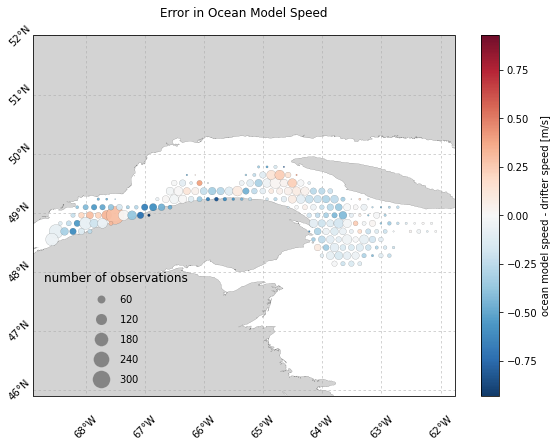

In [138]:
def plot_error_map(ds):
    
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(1, 1)
    ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    
    # define the variables for convenience
    lons = wrap_to_180(np.concatenate(ds.lon.values))
    lats = np.concatenate(ds.lat.values)
    speed_ocean_error = np.concatenate(ds.speed_ocean_error.values)
    map_extremes = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
    
    # calculate the hexbin size, bin values and number of counts per bin
    hexsize = calculate_hexbin_size(fig, ax, map_extremes)
    stats = get_stats_info(lats, lons, speed_ocean_error, hexsize)
    vextremes = find_extremes_centered_on_zero(stats['bin_vals'])
    
    ######################################
    # make the plot:
    ######################################
    scatter = ax.scatter(stats['lons_vals'], stats['lats_vals'], 
        c=stats['bin_vals'], 
        s=stats['bin_counts'], 
        zorder=100, 
        vmin=vextremes[0],
        vmax=vextremes[1],
        cmap='RdBu_r',
        edgecolor='black',
        linewidth=0.1,
        alpha=0.95
    ) 
    
    ######################################
    # add legends:
    #####################################
    
    ## Produce a legend for the colors that only shows 5 entries.
    #legend1 = ax.legend(*scatter.legend_elements(num=5), 
    #                    loc="upper left", 
    #                    title="ocean model speed minus \ndrifter speed [m/s]")
    #ax.add_artist(legend1)

    # Add a legend for the sizes. 
    kw = dict(prop="sizes", num=5, color = 'gray')  # color=scatter.cmap(0.25))
    legend2 = ax.legend(*scatter.legend_elements(**kw), 
                        loc="lower left", 
                        title="number of observations",
                        borderaxespad=0.7,
                        frameon=False,
                        labelspacing=0.8,
                        title_fontsize="large")
    
    ######################################
    # add colorbar:
    #####################################
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('ocean model speed - drifter speed [m/s]') 

    ######################################
    # add land, ocean color, etc:
    ######################################
    refine_map(ax, map_extremes)

    ######################################
    # tidy up then save the plot:
    ######################################
    ax.set_title('Error in Ocean Model Speed')

    # Tidy up the plot then save it.
    fig.tight_layout()
    fig.savefig(
        os.path.join(plotdir, ('error_map_alt.png')),
        bbox_inches='tight', 
        dpi=300
    )
    plt.show()
    plt.close()
    
plot_error_map(ds)

## Create the alternate version of the bubble plot (the one with two legends outside the plot area)

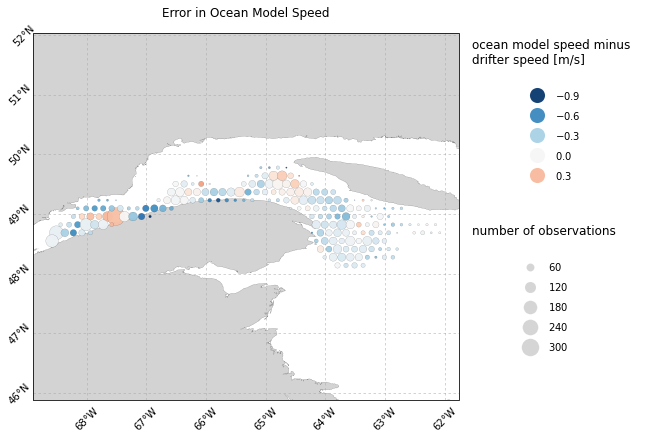

In [139]:
def plot_error_map_alt(ds):
       
    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 0.4])
    gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.05, hspace=0.03)

    # Add the map to the left hand side of the figure:
    ax = fig.add_subplot(gs[0:, 0:2], projection=ccrs.PlateCarree())
    
    # Define the variables for convienience
    lons = wrap_to_180(np.concatenate(ds.lon.values))
    lats = np.concatenate(ds.lat.values)
    speed_ocean_error = np.concatenate(ds.speed_ocean_error.values)
    map_extremes = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
    
    # calculate the hexbin size, bin values, and number of counts per bin
    hexsize = calculate_hexbin_size(fig, ax, map_extremes)
    stats = get_stats_info(lats, lons, speed_ocean_error, hexsize)
    vextremes = find_extremes_centered_on_zero(stats['bin_vals'])
       
    ######################################
    # make the plot:
    ######################################
    scatter = ax.scatter(
        stats['lons_vals'], stats['lats_vals'], 
        c=stats['bin_vals'], 
        s=stats['bin_counts'], 
        zorder=100, 
        vmin=vextremes[0],
        vmax=vextremes[1],
        cmap='RdBu_r',
        edgecolor='black',
        linewidth=0.1,
        alpha=0.95
    ) 
    
    ######################################
    # add legends:
    #####################################
       
    # Add legends outside the plot area in an unused grid element
    ax2 = plt.subplot(gs[0, 2])
    ax2.legend(*scatter.legend_elements(num=5), 
               loc="upper left",
               title="ocean model speed minus \ndrifter speed [m/s]\n",
               borderaxespad=0.1,
               frameon=False,
               labelspacing=0.8,
               title_fontsize="large",
               markerscale=2.5
               )
    ax2.patch.set_visible(False)
    ax2.axis('off')
    
    ax3 = plt.subplot(gs[1, 2])
    kw = dict(prop="sizes", num=5, color = 'lightgray')
    ax3.legend(*scatter.legend_elements(**kw),
               loc="upper left", 
               title="number of observations\n",
               borderaxespad=0.1,
               frameon=False,
               labelspacing=0.8,
               title_fontsize="large",
              )
    ax3.patch.set_visible(False)
    ax3.axis('off')
    
    ######################################
    # add land, ocean color, etc:
    ######################################
    refine_map(ax, map_extremes)

    ######################################
    # Tidy up the plot then save:
    ######################################
    ax.set_title('Error in Ocean Model Speed')
    fig.savefig(
        os.path.join(plotdir, ('error_map_alt.png')),
        bbox_inches='tight',
        dpi=300
    )
    plt.show()
    plt.close()

plot_error_map_alt(ds)